# EDA

## Analysis the original data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pandas_profiling

In [2]:
df = pd.read_csv('my_data/train.csv')

In [3]:
profile_before_transformation = pandas_profiling.ProfileReport(df)
profile_before_transformation.to_file('report before transformation.html')
profile_before_transformation

Summarize dataset:   0%|          | 0/25 [00:00<?, ?it/s]

c:\users\user\appdata\local\programs\python\python39\lib\site-packages\scipy\stats\stats.py:4594: RuntimeWarning: overflow encountered in longlong_scalars
  (2 * xtie * ytie) / m + x0 * y0 / (9 * m * (size - 2)))


Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

The dataset consists of 100000 rows and 12 variables.

***

**PassengerId, Name, Ticket, Cabin**

This variables are categorical. The number of their distinct values is comparable to the length of dataset. So they will be ignored.

***

**Survived** (*target*)

This variable is categorical. Its values are *0*, *1*. The frequncies are below.
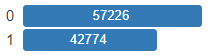
The class 0 is larger than the class 1 but this difference not very large. So these classes are comparable to each other. It means that such characteristics as accuracy and AUC-ROC can be used for estimating the quality of models.
***

**Pclass**

This variable is categorical. Its values are *1, 2, 3*. The frequencies are below.
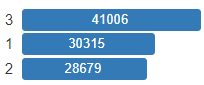
These classes are large enough to combine them. Also this variable is ordinal because the greater *Pclass* value means the better class of cabin.
***

**Sex**

This variable is categorical. Its values are *male* and *female*. The frequncies are below.
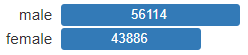
These values can be transformed by rule (male: 0, female: 1).
***

**Age**

This variable is numeric. The distribution is below.
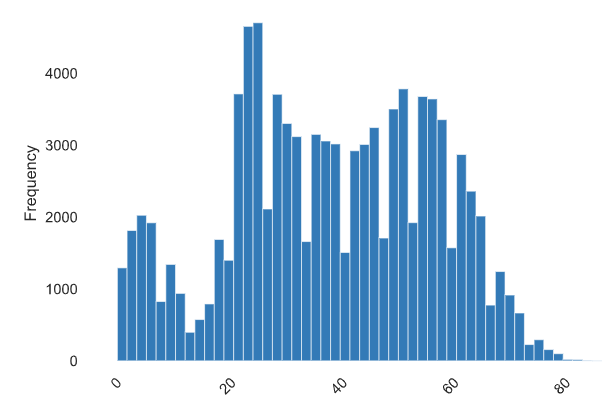
It can be transformed into variable by such way. Let $0 = a_0 < a_1 < a_2 < ... < a_k < a_{k+1} = \infty$ - some numbers. Then the new variable equals n if age is in $[a_n, a_{n+1})$. The numbers $a_i$ are such that the sizes of obtained classes almost equals to each other. The number of classes is 5.

There are 3.3% missing values. These values can be predicted using other untargeted variables. But if to split the train dataset without missings into "train" and "test", the decision tree and logistic regression fitted on "train" dataset give the score 0.31 on the "test" one. As the number of classes is 5 and they have almost the same size, this prediction is a little better than random prediction. So these values are removed.
***

**SibSp**

This variable is categorical. Its values are *0, 1, 2, 3, 4, 5, 8*. The frequencies are below.
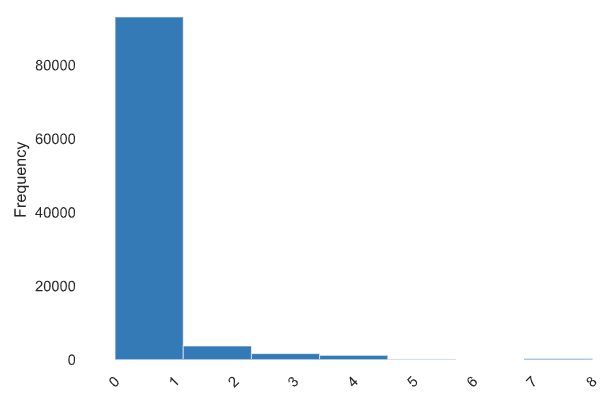
The most frequent value is *0* (73.3%). The value *1* has frequency 19.8%. So the values *2, 3, 4, 5, 8* can be combined in one value which has frequency 6.9%.
***

**Parch**

This variable is categorical. Its values are *0, 1, 2, 3, 4, 5, 6, 9*. The frequencies are below.
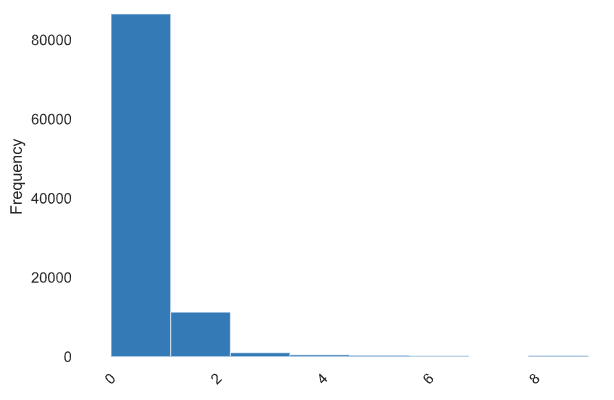
The values *0, 1, 2* has frequencies 73.5%, 13.0% and 11.2%. So the values *3, 4, 5, 6, 9* can be combined in one value with frequency 2.3%.

Also it is possible to add this variable with "SibSp". The result is the amount of all relatives in the ship.
***

**Fare**

This variable is numeric. The distribution is below.
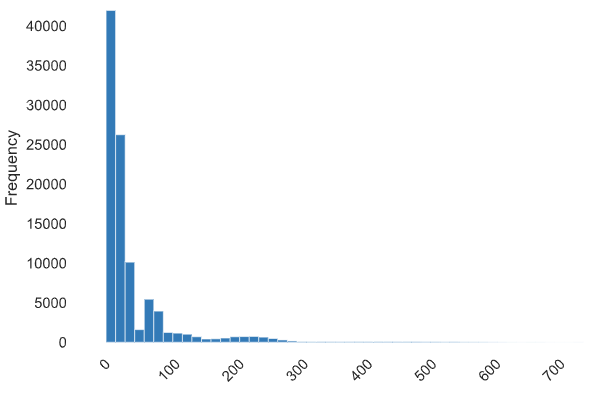
The minimum value is 0.68, the maximum value is 744.66 and the 95-th percentile is 196.7. It means that this variable should be transformed as variable "Age" because such extremal values can impact on the quality of models (e.g. linear regression, SVM).
There are 0.13% missing values. So the rows with missing values "Fare" will be removed.
***

**Embarked**

This variable is categorical. Its values are *S, C, Q*. The frequencies are below.
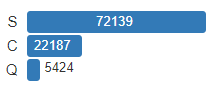
As it is not ordinal variable it should be changed into three ones: "S", "C", "Q". Variable S equals 1 if "Embarked" value is "S" and 0 otherwise. Other variables are the same.
There are 0.25% missing values. So the rows with missing values "Fare" will be removed.

## Transformation

In [3]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, KBinsDiscretizer
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer

In [4]:
class MyTransformer(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.tr = ColumnTransformer([('sex_encoding', OrdinalEncoder(categories=[['male', 'female']]), ['Sex']),
                                     ('age_encoding', KBinsDiscretizer(n_bins=5, encode='ordinal'), ['Age', 'Fare']),
                                     ('embarked_encoding', OneHotEncoder(categories=[['C', 'Q', 'S']]), ['Embarked'])
                                     ])
    def drop_unimportant_features_and_nans(self, X):
        return X.drop(['PassengerId', 'Name', 'Ticket', 'Cabin'], axis=1).dropna()
    def fit(self, X):
        self.tr.fit(self.drop_unimportant_features_and_nans(X))
        return self
    def transform(self, X):
        X_full = self.drop_unimportant_features_and_nans(X)
        X_transformed = pd.DataFrame(data=self.tr.transform(X_full), columns=['Sex', 'Age', 'Fare', 'C', 'Q', 'S'])
        X_transformed['Relatives'] = KBinsDiscretizer(n_bins=3, encode='ordinal').fit_transform(np.reshape(list(X_full['SibSp'] + X_full['Parch']), (-1, 1)))
        X_transformed['Survived'] = X_full['Survived'].to_numpy()
        X_transformed['Pclass'] = X_full['Pclass'].to_numpy()
        return X_transformed

In [5]:
tr = MyTransformer()
transformed_df = tr.fit_transform(df)

c:\users\user\appdata\local\programs\python\python39\lib\site-packages\sklearn\preprocessing\_discretization.py:220: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn('Bins whose width are too small (i.e., <= '


In [7]:
transformed_df.to_csv('my_data/transformed_train.csv', index=False)

In [29]:
profile_after_transformation = pandas_profiling.ProfileReport(transformed_df)
profile_before_transformation.to_file('report after transformation.html')
profile_after_transformation

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

Summarize dataset:   0%|          | 0/22 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

--------------------------

Variables after transformation:
***
**Age**

This variable has become a categorical one. The frequencies are below.
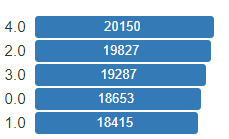
The rule of transformation is descibed in part 1.1.

***
**Fare**

This variable has become a categorical one. The frequencies are below.
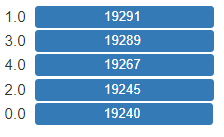
The rule of transformation is descibed in part 1.1.

***
**C, Q, S**

These variables indicate the value of variable Embarked. Its values' frequencies are below:
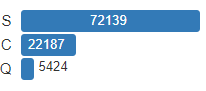
As the size of dataset where "Embarked" has value Q is about 5%, there is a big correlation between new variables "C" and "S" (C+S=1 in 95% cases)

***
**Relatives**

This variable has become a categorical one. The frequencies are below.
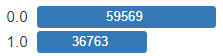
People without any relatives on the ship form the "0" class. All the others form the "1" class.


The correlation matrix of obtained variables is below.
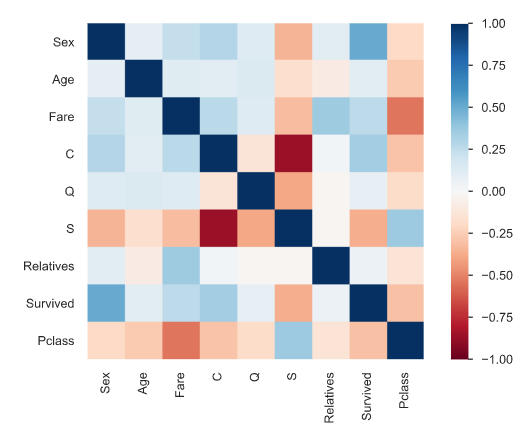
The target variable "Survived" mostly correlates with variables "Sex", "S", "C". There is relatively high correlation between variables "Pclass" and "Fare". The correlation between "C" and "S" is about 1. For some models (e.g. linear regression) it can be a trouble. So in some cases at least one of them should be removed.